In [3]:
import pandas as pd
from pydantic import BaseModel, ConfigDict
import numpy as np
import numpy.typing as npt
from typing import Any, Callable
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.signal import spectrogram, convolve, ShortTimeFFT, windows
from scipy.fftpack import fftshift

from sklearn.preprocessing import StandardScaler

from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as tfunc
from torch import func

from os import PathLike
from functools import partial
from typing import Self

from scipy import signal

from pathlib import Path

from pre_processor import PreProcessorDataset

from itertools import islice
import pywt

In [4]:
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print("-"*80)
    print("using mps device")
    print("-"*80)

else: 
    DEVICE = torch.device('cpu')
    print("no mps available falling back to cpu")


--------------------------------------------------------------------------------
using mps device
--------------------------------------------------------------------------------


In [5]:
filename_prefix = "01"
pre_ds2 = PreProcessorDataset.load_from_disk(filepath_data=f"{filename_prefix}_eeg_ppd_data.npy", filepath_metadata = f"{filename_prefix}_eeg_ppd_metadata.parquet")

In [6]:
pre_ds2.metadata.dtypes

id            int64
event         int64
device     category
channel    category
code          int64
size          int64
dtype: object

# Explore Spectrograms from Specific Events

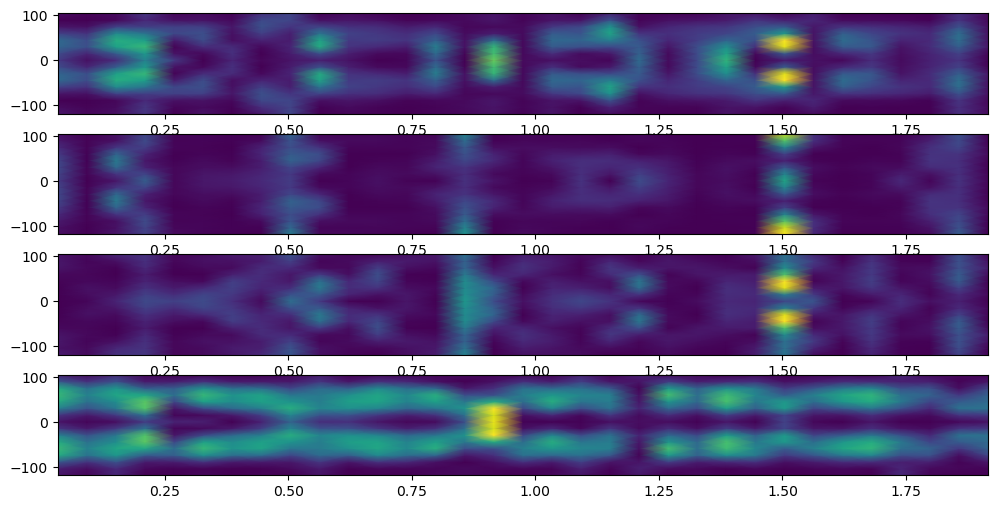

In [25]:

for meta, data in islice(pre_ds2.enumerate_events(), 1001, 1002):

    if (meta["code"] == -1).all():
        continue
    # length = data.shape[-1]
    # print(meta)
    # print(data)

    label = meta["code"].iloc[0]
    length = meta["size"].iloc[0]


    fig, axes = plt.subplots(4, 1, figsize = (12,6), squeeze=True)

    # np.sum(data, axis = 1)
    # wt, dt = pywt.dwt(data[:,0:length], "haar")
    # # print(wt[0])

    # plt.plot(dt[0])
    # break

    sub_arrs = []
    for rec, ax in (zip(data, axes)):
        # record = parsed_lines[idx]
        norm_rec = (rec[0:length]  - np.mean(rec[0:length]))/np.std(rec[0:length])
        #trimming to unpadded length improves plot scaling
        f, t, Sxx = spectrogram(rec[0:length], fs = length/2, nperseg=(win:=16), noverlap=win//8, return_onesided=False, window = "flattop")
        ax.pcolormesh(t, fftshift(f), fftshift((Sxx), axes=0), shading = 'gouraud')
    

In [222]:



arrs = []
labels = []
for meta, data in (pre_ds2.enumerate_events()):

    if (meta["code"] == -1).all():
        continue
    # length = data.shape[-1]
    # print(meta)
    # print(data)

    label = meta["code"].iloc[0]
    length = meta["size"].iloc[0]

    

    # fig, axes = plt.subplots(4, 1, figsize = (12,6), squeeze=True)
    sub_arrs = []
    for rec in ((data)):
        # record = parsed_lines[idx]

        trimmed_data = rec[0:length]

        norm_data = (trimmed_data - np.mean(trimmed_data))/np.std(trimmed_data)

        norm_padded_data = np.zeros((data.shape[-1]))
        norm_padded_data[0:length] = norm_data

        f, t, Sxx = spectrogram(norm_padded_data, fs = length/2, nperseg=(win:=16), noverlap=win//8, return_onesided=False, window = "flattop")
        # ax.pcolormesh(t, fftshift(f), fftshift((Sxx), axes=0), shading = 'gouraud')
        
        sub_arrs.append(Sxx)
    
    sub_arrs = np.stack(sub_arrs)

    arrs.append(sub_arrs)
    labels.append(label)
    # break


    
    

    

In [224]:
spec_grams = np.stack(arrs)
labels = np.stack(labels)

np.save("eeg_spectrogram_data.npy", spec_grams)
np.save("eeg_spectrogram_labels.npy", labels)

In [212]:
print(f"{labels.shape=}")
print(f"{spec_grams.shape = }")

labels.shape=(29880,)
spec_grams.shape = (29880, 4, 16, 43)


In [213]:
class CustomEEGDataset(Dataset):
    def __init__(self, data: torch.Tensor, labels: torch.Tensor, max_len=None) -> None:
        # self.metadata = metadata
        self.event_data = data
        self.labels = labels
        # self.transform = transform

    @classmethod
    def from_npy_files(
        cls,
        spectrogram_path: PathLike,
        labels_path: PathLike,
        device=None,
        transform=None,
    ):
        spectrogram_array = torch.tensor(
            np.load(spectrogram_path), device=device, dtype=torch.float32
        )
        # vector_one_hot =  func.vmap(nn.functional.one_hot,in_dims = 0)

        labels_array =nn.functional.one_hot(torch.tensor(
            np.load(labels_path), device=device, dtype=torch.int64
        ), num_classes=10)
        # print(labels_array)


        return cls(spectrogram_array, labels_array)

    def __getitem__(self, index) -> Any:
        return self.event_data[index], self.labels[index]

    def __len__(self):
        return self.labels.shape[0]

    @classmethod
    def split(
        cls, other_cls: Self, prop=0.25, seed=1, sampling=1.0, device = None
    ) -> tuple[Self, Self]:
        rng = np.random.default_rng(seed)
        idxes = np.arange(0, len(other_cls), 1)
        rng.shuffle(idxes)
        new_len = int(round(len(other_cls) * sampling))

        idxes = idxes[0:new_len]

        num_test = round(new_len * prop)

        # df_metadata = other_cls.metadata
        event_data = other_cls.event_data
        labels = other_cls.labels

        test_event_data = event_data[idxes[0:num_test]]
        test_labels = labels[idxes[0:num_test]]

        train_event_data = event_data[idxes[num_test:]]
        train_labels = labels[idxes[num_test:]]

        return cls(
            train_event_data.detach().to(device),
            train_labels.detach().to(device),
        ), cls(
            test_event_data.detach().to(device),
            test_labels.detach().to(device),
        )

In [225]:
class Spec4ChannelConv2d(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        
        self.conv1 = nn.Conv2d(4,8,(2,2))
        # self.conv2 = nn.Conv2d(8,8,(2,2))
        # self.conv3 = nn.Conv2d(8,8,(2,2))
        self.conv4 = nn.Conv2d(8,8,(2,2))
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(3)


        self.rel = nn.ReLU()
        self.flat = nn.Flatten()
        self.drop = nn.Dropout2d(0.2)


    def forward(self, x):
        
        x = self.pool1(self.rel(self.conv1(x)))
        x  = self.drop(x)
        # x = (self.rel(self.conv2(x)))
        # x = (self.rel(self.conv3(x)))
        x = self.pool2(self.rel(self.conv4(x)))
        x = self.flat(x)
        return x

In [232]:
class EEGModel(nn.Module):

    def __init__(self, ) -> None:
        super().__init__()
        self.ch1_conv = Spec4ChannelConv2d()
        self.ch2_conv = Spec4ChannelConv2d()
        self.ch3_conv = Spec4ChannelConv2d()
        self.ch4_conv = Spec4ChannelConv2d()
    

        self.pool1 = nn.MaxPool2d(4)
        self.pool2 = nn.MaxPool1d(8)
        self.pool3 = nn.MaxPool1d(8)

        self.drop = nn.Dropout(p = 0.2)
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(384,512)
        self.lin2 = nn.Linear(512,64)

        self.lin6  = nn.Linear(64, 10)
        
        self.rel = nn.ReLU()
    
    def forward(self, x: torch.Tensor):
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        x4 = x[3]

        x1 = self.ch1_conv.forward(x)
        x2 = self.ch2_conv.forward(x)
        x3 = self.ch3_conv.forward(x)
        x4 = self.ch4_conv.forward(x)

        x = torch.cat((x1, x2, x3, x4), dim = 1)

        x = self.drop(x)

        x = self.flat(x)
        x = self.rel(self.lin1(x))
        x = self.rel(self.lin2(x))

        logits = self.lin6(x)

        return logits
    

In [233]:


def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss, optimizer: torch.optim.Optimizer, batch_size: int):
    
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(X.unsqueeze(0).shape)

        pred = model(X.float())
        loss = loss_fn(pred, y.float())
        # print(pred[0])
        # print(y[0])

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader:DataLoader, model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X.float())
            
            test_loss += loss_fn(pred, y.float()).item()

            correct += (pred.argmax(axis = 1) == y.float().argmax(axis = 1)).type(torch.float).sum().item()

            # print(pred)
            

    print(f"{batch= }")
    print(f"{size = }")
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss

In [234]:
ds = CustomEEGDataset.from_npy_files("eeg_spectrogram_data.npy", "eeg_spectrogram_labels.npy", device = DEVICE)

train_ds, test_ds = CustomEEGDataset.split(ds, device = DEVICE)

In [238]:
BATCH_SIZE = 64
train_data = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_data = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)


In [239]:
learning_rate = 0.001
batch_size = BATCH_SIZE
# epochs = 1

model = EEGModel().to(DEVICE)
print(model)
# model

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps = 1e-8)
loss_fn = nn.CrossEntropyLoss()

EEGModel(
  (ch1_conv): Spec4ChannelConv2d(
    (conv1): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
    (conv4): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (rel): ReLU()
    (flat): Flatten(start_dim=1, end_dim=-1)
    (drop): Dropout2d(p=0.2, inplace=False)
  )
  (ch2_conv): Spec4ChannelConv2d(
    (conv1): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
    (conv4): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (rel): ReLU()
    (flat): Flatten(start_dim=1, end_dim=-1)
    (drop): Dropout2d(p=0.2, inplace=False)
  )
  (ch3_conv): Spec4ChannelConv2d(
    (conv1): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
    (conv

In [240]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 5
metrics = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_data, model, loss_fn, optimizer, batch_size=BATCH_SIZE)
    accuracy, test_loss  = test_loop(test_data, model, loss_fn)
    metrics.append({"epoch": t, "accuracy":accuracy, "test_loss":test_loss})
print("Done!")

df_metrics = pd.DataFrame.from_records(metrics)
df_metrics.to_csv("test_metrics.csv")

Epoch 1
-------------------------------
loss: 2.300663  [   64/22410]
loss: 2.310948  [ 6464/22410]
loss: 2.316763  [12864/22410]
loss: 2.303688  [19264/22410]
batch= 116
size = 7470
Test Error: 
 Accuracy: 10.1%, Avg loss: 2.303420 

Epoch 2
-------------------------------
loss: 2.303851  [   64/22410]
loss: 2.305186  [ 6464/22410]
loss: 2.306567  [12864/22410]
loss: 2.303820  [19264/22410]
batch= 116
size = 7470
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.303309 

Epoch 3
-------------------------------
loss: 2.298244  [   64/22410]
loss: 2.305279  [ 6464/22410]


KeyboardInterrupt: 